# Chapter 5: Convolutional Neural Networks (CNNs)

This notebook covers **Chapter 5** of the Deep Learning in Hebrew book, focusing on Convolutional Neural Networks (CNNs). We'll learn how to build networks that are efficient for image data and can learn spatial patterns.

## Overview

The networks described so far are **Fully-Connected (FC)** - each neuron in each layer is connected to every neuron in the next layer. This approach is computationally expensive, and often there is no need for all connections between neurons.

For example, a grayscale image of 256×256×1 pixels fed into an FC network with N=1000 neurons would require 65 million connections, all of which need to be updated during learning. If there are many layers, the number becomes enormous, and the amount of connections and parameters grows exponentially, making it difficult to maintain the network.

Besides the size problem, in practice there is not always a need for all connections, since there is not always a relationship between all input elements. For example, for an image fed into a network, in many tasks the relationship between distant pixels is not significant, so there is no importance in connecting the input to all neurons in the first layer and connecting all layers fully.

Instead, it is common to use layers with fewer connections and not connect every two neurons, but only between nearby elements, as will be detailed. Many modern networks are based on **convolutional layers**, on top of which advanced architectures have been built.

---

## Table of Contents

### 5.1 Convolutional Layers
- 5.1.1 [From Fully-Connected Layers to Convolutions](#511-from-fully-connected-layers-to-convolutions)
- 5.1.2 [Padding, Stride and Dilation](#512-padding-stride-and-dilation)
- 5.1.3 [Pooling](#513-pooling)
- 5.1.4 [Training](#514-training)
- 5.1.5 [Convolutional Neural Networks (LeNet)](#515-convolutional-neural-networks-lenet)

### 5.2 CNN Architectures
- 5.2.1 [AlexNet](#521-alexnet)
- 5.2.2 [VGG](#522-vgg)
- 5.2.3 [GoogleNet](#523-googlenet)
- 5.2.4 [Residual Networks (ResNet)](#524-residual-networks-resnet)
- 5.2.5 [Densely Connected Networks (DenseNet)](#525-densely-connected-networks-densenet)
- 5.2.6 [U-Net](#526-u-net)
- 5.2.7 [Transfer Learning](#527-transfer-learning)

## Setup and Imports

Let's start by importing the necessary libraries for this chapter.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 5.1 Convolutional Layers

## 5.1.1 From Fully-Connected Layers to Convolutions

A **convolutional layer** is a type of layer that performs a linear operation on the input in order to obtain a different and simpler representation of it. Usually, a convolutional layer performs a **cross-correlation** operation between a weight vector and a certain input (input vector or output vector from a hidden layer).

The weight vector is called the **convolution kernel** (or **filter**), and with its help the cross-correlation operation is performed:

$$y[n] = \sum_{m=0}^{M-1} x[n-m] w[m]$$

where $x \in \mathbb{R}^N$ is the input vector and $w \in \mathbb{R}^M$ is the weight vector.

### Parameter Sharing

The key insight is that the weights $w$ are **shared** across all inputs in the layer, so the number of learned parameters in a convolutional layer is much smaller than in an FC layer - an FC layer contains $N_{input} \times N_{output}$ weights, while a convolutional layer contains only $K$ weights (usually $K \ll N_{input} \times N_{output}$).

### Feature Detection

Besides reducing the number of weights, the convolution operation helps identify patterns and find features. This capability comes from the fact that the convolution operation checks the similarity between the input vector and the convolution kernel. The convolution can find features in the signal, and there are convolution kernels that can perform a set of useful operations, such as smoothing, derivative, and more.

If we apply many different kernels to an image, we can find all kinds of features in it - for example, if the kernel is in the shape of an eye or nose, then it can find the regions in the original image similar to an eye or nose.

### Activation Maps

The output of the convolutional layer passes through a non-linear activation function (usually tanh or ReLU), and it is called an **activation map** or **feature map**.

Usually, in each convolutional layer there will be several filters, each of which is supposed to learn a different feature in the image. As the network goes deeper, the features become more abstract and distinguished, and in the deeper layers the filters identify more complex features like parts of objects, while in the deeper layers the filters identify even more complex features like complete objects or shapes.

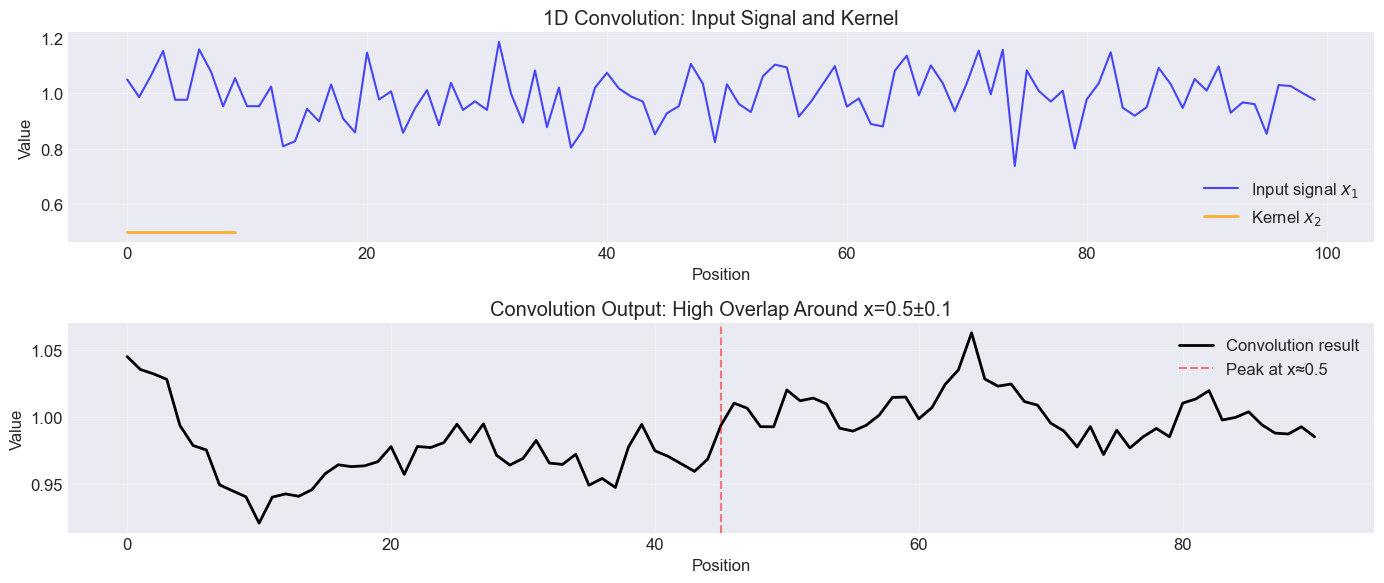

Input size: 100
Kernel size: 10
Output size: 91


In [3]:
# 1D Convolution Example
def conv1d(x, kernel):
    """
    Perform 1D convolution (cross-correlation).
    
    Parameters:
    -----------
    x : array, shape (N,)
        Input signal
    kernel : array, shape (M,)
        Convolution kernel/filter
    
    Returns:
    --------
    y : array
        Output after convolution
    """
    N = len(x)
    M = len(kernel)
    output_size = N - M + 1
    y = np.zeros(output_size)
    
    for n in range(output_size):
        y[n] = np.sum(x[n:n+M] * kernel)
    
    return y

# Example: Edge detection
np.random.seed(42)
# Create a signal (rectangle with small noise)
x = np.ones(100)
x[40:60] = 1.0
x = x + np.random.randn(100) * 0.1

# Create a rectangular kernel
kernel = np.ones(10) / 10  # Moving average filter

# Perform convolution
y = conv1d(x, kernel)

# Visualize
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(x, 'b-', linewidth=1.5, label='Input signal $x_1$', alpha=0.7)
plt.plot(kernel * 5, 'orange', linewidth=2, label='Kernel $x_2$', alpha=0.8)
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('1D Convolution: Input Signal and Kernel')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(y, 'k-', linewidth=2, label='Convolution result')
plt.axvline(x=45, color='r', linestyle='--', alpha=0.5, label='Peak at x≈0.5')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Convolution Output: High Overlap Around x=0.5±0.1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Input size: {len(x)}")
print(f"Kernel size: {len(kernel)}")
print(f"Output size: {len(y)}")

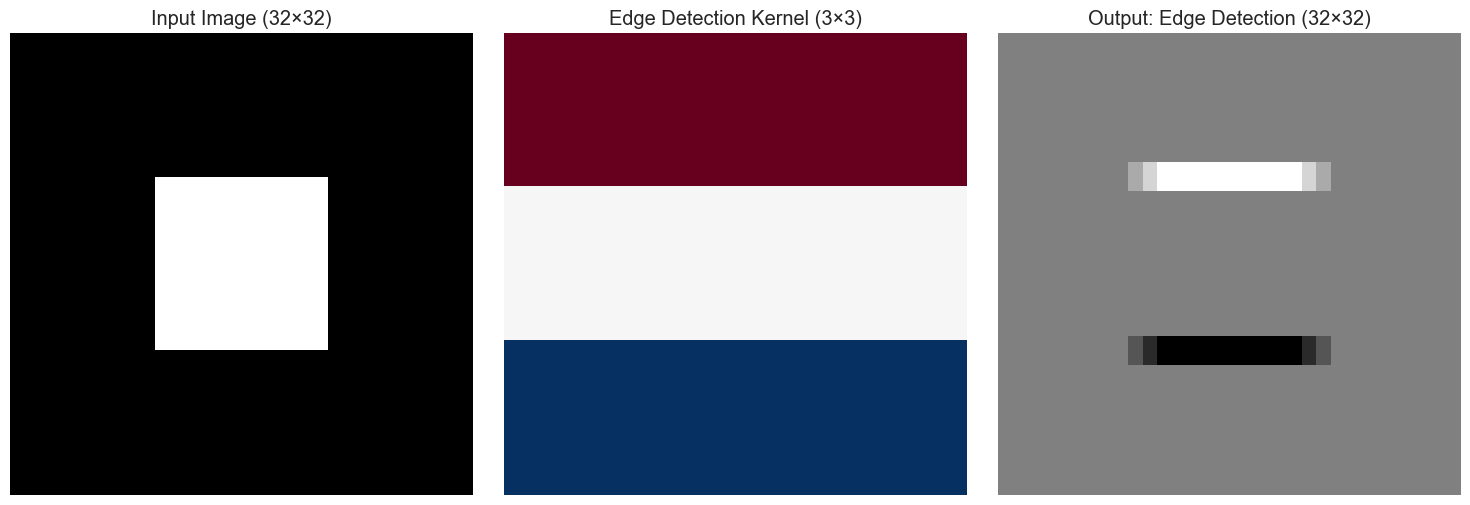

Input shape: (32, 32)
Kernel shape: (3, 3)
Output shape: (32, 32)


In [4]:
# 2D Convolution for Images
def conv2d(image, kernel, padding=0, stride=1):
    """
    Perform 2D convolution (cross-correlation) on an image.
    
    Parameters:
    -----------
    image : array, shape (H, W) or (H, W, C)
        Input image
    kernel : array, shape (K, K) or (K, K, C)
        Convolution kernel
    padding : int
        Padding size
    stride : int
        Stride size
    
    Returns:
    --------
    output : array
        Convolved output
    """
    # Handle grayscale vs color
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    if len(kernel.shape) == 2:
        kernel = kernel[:, :, np.newaxis]
    
    H, W, C = image.shape
    K, _, _ = kernel.shape
    
    # Add padding
    if padding > 0:
        image_padded = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
    else:
        image_padded = image
    
    # Calculate output dimensions
    out_h = (H + 2*padding - K) // stride + 1
    out_w = (W + 2*padding - K) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    # Perform convolution
    for i in range(0, out_h):
        for j in range(0, out_w):
            h_start = i * stride
            w_start = j * stride
            h_end = h_start + K
            w_end = w_start + K
            
            # Extract region and apply kernel
            region = image_padded[h_start:h_end, w_start:w_end, :]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Example: Edge detection on 2D image
# Create a simple test image
test_image = np.zeros((32, 32))
test_image[10:22, 10:22] = 1.0  # White square

# Edge detection kernel (Sobel-like)
edge_kernel = np.array([[-1, -1, -1],
                        [0, 0, 0],
                        [1, 1, 1]])

# Apply convolution
edge_detected = conv2d(test_image, edge_kernel, padding=1, stride=1)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Input Image (32×32)')
axes[0].axis('off')

axes[1].imshow(edge_kernel, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Edge Detection Kernel (3×3)')
axes[1].axis('off')

axes[2].imshow(edge_detected, cmap='gray')
axes[2].set_title('Output: Edge Detection (32×32)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Input shape: {test_image.shape}")
print(f"Kernel shape: {edge_kernel.shape}")
print(f"Output shape: {edge_detected.shape}")

### Multi-Channel Input and Output

The input of a convolutional layer can be **multi-channel** (for example, a color image is usually represented using RGB values). In this case, the convolution operation is performed on each channel separately, and then the results are summed to produce a single output channel.

The convolution can be a multi-dimensional vector operating on a certain input, but it can also be of higher dimension. Usually, filters operating on images are two-dimensional, and the convolution operation is performed between the filter and the image in a spatial manner.

For a filter $F \in \mathbb{R}^{5 \times 5 \times 3}$ operating on input $x \in \mathbb{R}^{32 \times 32 \times 3}$, we get an activation map $y \in \mathbb{R}^{28 \times 28}$.

The input can pass through multiple filters and produce an activation map with multiple layers - for six filters, the dimension of the map is $y \in \mathbb{R}^{28 \times 28 \times 6}$.

Input shape: (32, 32, 3)
Number of filters: 6
Each filter shape: (5, 5, 3)
Output feature map shape: (28, 28, 6)


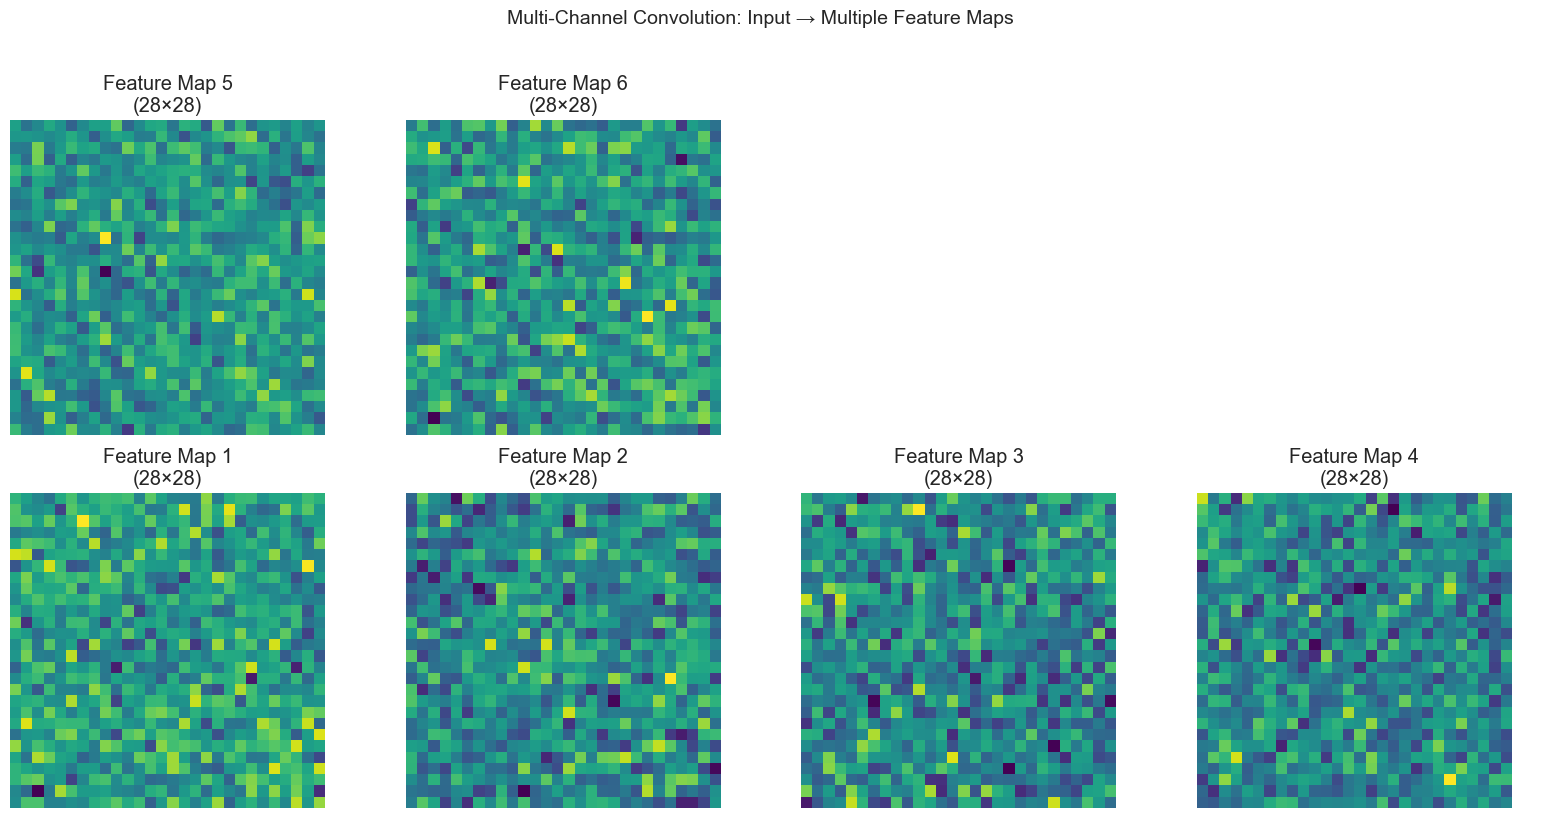

In [5]:
# Multi-channel convolution example
# Create RGB image (32×32×3)
rgb_image = np.random.rand(32, 32, 3)

# Create multiple filters (5×5×3 each)
num_filters = 6
filters = np.random.randn(5, 5, 3, num_filters)

# Apply each filter
output_maps = []
for i in range(num_filters):
    # For each filter, convolve across all channels and sum
    output = np.zeros((28, 28))
    for c in range(3):  # RGB channels
        channel_output = conv2d(rgb_image[:, :, c], filters[:, :, c, i], padding=0, stride=1)
        output += channel_output
    output_maps.append(output)

# Stack outputs
feature_map = np.stack(output_maps, axis=2)

print(f"Input shape: {rgb_image.shape}")
print(f"Number of filters: {num_filters}")
print(f"Each filter shape: {filters[:, :, :, 0].shape}")
print(f"Output feature map shape: {feature_map.shape}")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show input RGB image
axes[0, 0].imshow(rgb_image)
axes[0, 0].set_title('Input: RGB Image\n(32×32×3)')
axes[0, 0].axis('off')

# Show one filter (averaged across channels for visualization)
axes[0, 1].imshow(filters[:, :, :, 0].mean(axis=2), cmap='RdBu')
axes[0, 1].set_title('Example Filter\n(5×5×3)')
axes[0, 1].axis('off')

axes[0, 2].axis('off')
axes[0, 3].axis('off')

# Show feature maps
for i in range(6):
    row = 1 if i < 4 else 0
    col = (i % 4) if i < 4 else i - 4
    if i < 6:
        axes[row, col].imshow(feature_map[:, :, i], cmap='viridis')
        axes[row, col].set_title(f'Feature Map {i+1}\n(28×28)')
        axes[row, col].axis('off')

plt.suptitle('Multi-Channel Convolution: Input → Multiple Feature Maps', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5.1.2 Padding, Stride and Dilation

Like in FC networks, in convolutional networks there are **hyperparameters** that determine the network's behavior. There are three main hyperparameters of the convolutional layer - the size of the filter, the number of channels of the input, and parameters that determine how the convolution operation is performed:

### Padding

**Padding** is an operation that adds zeros (or replicates edge values) around the input to allow the convolution operation to be performed on the edges as well. The convolution operation is spatial, meaning the filter operates on a number of pixels, and there are pixels on the edges for which the convolution operation cannot be performed if the filter is not placed in these places.

For a filter of size $K \times K$, the required padding size is: $\text{Padding} = \frac{K-1}{2}$.

### Dilation

**Dilation** is used to reduce the number of calculations even more, by operating on larger regions under the assumption that geographically close values have the same value. For this purpose, we can apply the convolution with gaps between close elements. The parameter that controls this is $d = 2$.

### Stride

**Stride** is the step size - instead of applying the filter to every possible region in the network, we can perform jumps, so that after each convolution calculation, a jump of stride size is performed before the next convolution. A typical stride size is $s = 2$.

### Output Size Formula

The size of the output layer after performing convolution depends on the sizes of the input and filter, zero padding, and stride size. Formally, we can calculate the output layer size according to the formula:

$$O = \frac{W - K + 2P}{S} + 1$$

where:
- $W$ is the input size
- $K$ is the filter size
- $P$ is the padding size
- $S$ is the stride size

The number of layers in the output is equal to the number of filters (the output can be multi-channel). Note that the hyperparameter values (stride, padding, dilation) as well as the kernel size must be chosen so that $O$ is a natural number.

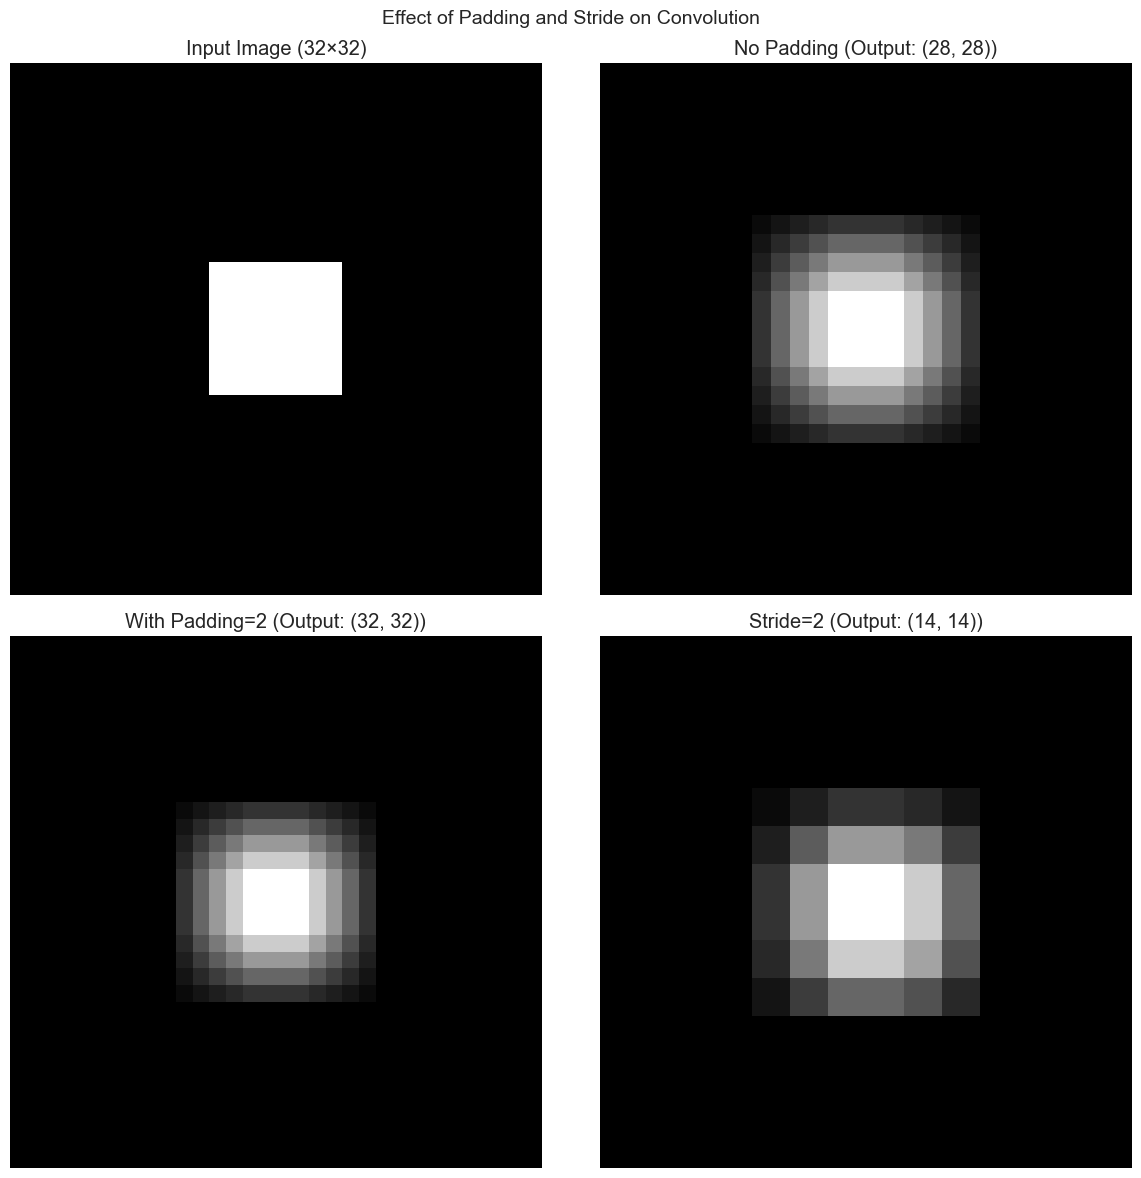

Output Size Calculations:
  Input size W = 32, Kernel size K = 5
  No padding, stride=1: O = (32 - 5 + 2×0)/1 + 1 = 28
  Padding=2, stride=1: O = (32 - 5 + 2×2)/1 + 1 = 32
  No padding, stride=2: O = (32 - 5 + 2×0)/2 + 1 = 14


In [6]:
# Demonstrate Padding, Stride, and Dilation
def visualize_conv_parameters():
    """Visualize the effect of padding, stride, and dilation."""
    # Create a simple image
    img = np.zeros((32, 32))
    img[12:20, 12:20] = 1.0
    
    kernel = np.ones((5, 5)) / 25  # 5×5 averaging kernel
    
    # No padding
    output_no_pad = conv2d(img, kernel, padding=0, stride=1)
    
    # With padding
    output_with_pad = conv2d(img, kernel, padding=2, stride=1)
    
    # With stride
    output_stride = conv2d(img, kernel, padding=0, stride=2)
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Input Image (32×32)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(output_no_pad, cmap='gray')
    axes[0, 1].set_title(f'No Padding (Output: {output_no_pad.shape})')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(output_with_pad, cmap='gray')
    axes[1, 0].set_title(f'With Padding=2 (Output: {output_with_pad.shape})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(output_stride, cmap='gray')
    axes[1, 1].set_title(f'Stride=2 (Output: {output_stride.shape})')
    axes[1, 1].axis('off')
    
    plt.suptitle('Effect of Padding and Stride on Convolution', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Calculate output sizes
    W, K, P, S = 32, 5, 2, 2
    O_no_pad = (W - K + 2*0) // S + 1
    O_with_pad = (W - K + 2*P) // S + 1
    
    print("Output Size Calculations:")
    print(f"  Input size W = {W}, Kernel size K = {K}")
    print(f"  No padding, stride=1: O = ({W} - {K} + 2×0)/1 + 1 = {output_no_pad.shape[0]}")
    print(f"  Padding={P}, stride=1: O = ({W} - {K} + 2×{P})/1 + 1 = {output_with_pad.shape[0]}")
    print(f"  No padding, stride={S}: O = ({W} - {K} + 2×0)/{S} + 1 = {output_stride.shape[0]}")

visualize_conv_parameters()

### Receptive Field

The **receptive field** of a value in the output of a network is defined to be all the domain in the input that affects that value in the output.

As we go deeper into the network, the receptive field grows, allowing neurons in deeper layers to "see" larger portions of the input image.

Receptive Field Calculation:
Three consecutive 3×3 convolutions:
  Layer 1: kernel=3×3, stride=1, padding=1
  Layer 2: kernel=3×3, stride=1, padding=1
  Layer 3: kernel=3×3, stride=1, padding=1

Total Receptive Field: 7×7


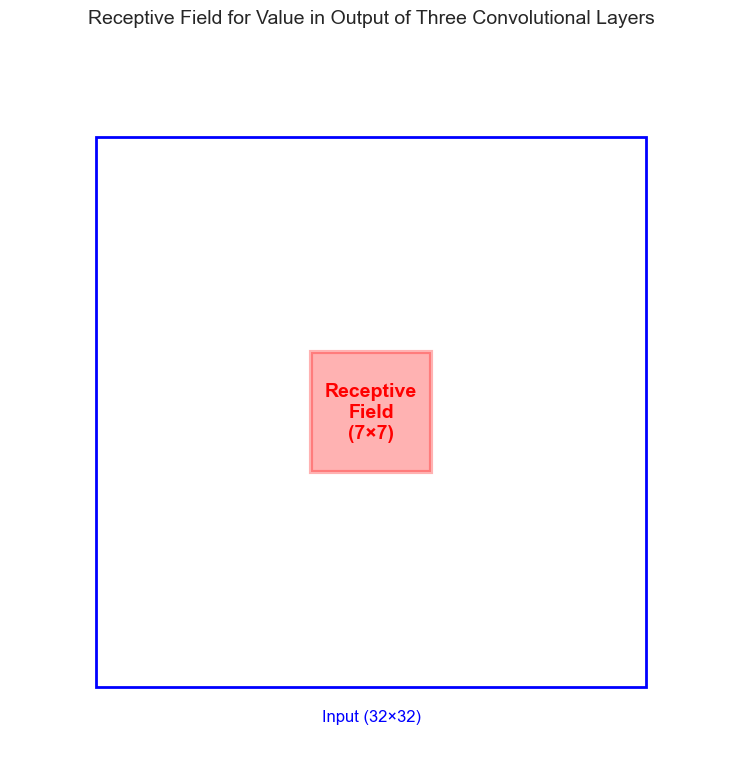

In [7]:
# Visualize Receptive Field
def calculate_receptive_field(layers):
    """
    Calculate receptive field size.
    
    Parameters:
    -----------
    layers : list of tuples (kernel_size, stride, padding)
        List of layer configurations
    
    Returns:
    --------
    rf : int
        Receptive field size
    """
    rf = 1
    for k, s, p in layers:
        rf = rf + (k - 1) * s
    return rf

# Example: Three consecutive 3×3 convolutions
layers = [(3, 1, 1), (3, 1, 1), (3, 1, 1)]
rf = calculate_receptive_field(layers)

print("Receptive Field Calculation:")
print("Three consecutive 3×3 convolutions:")
for i, (k, s, p) in enumerate(layers, 1):
    print(f"  Layer {i}: kernel={k}×{k}, stride={s}, padding={p}")
print(f"\nTotal Receptive Field: {rf}×{rf}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Draw input
input_size = 32
ax.add_patch(plt.Rectangle((0, 0), input_size, input_size, fill=False, edgecolor='blue', linewidth=2))
ax.text(input_size/2, -2, 'Input (32×32)', ha='center', fontsize=12, color='blue')

# Draw receptive field
rf_start = (input_size - rf) / 2
ax.add_patch(plt.Rectangle((rf_start, rf_start), rf, rf, fill=True, 
                          edgecolor='red', linewidth=3, facecolor='red', alpha=0.3))
ax.text(input_size/2, input_size/2, f'Receptive\nField\n({rf}×{rf})', 
       ha='center', va='center', fontsize=14, weight='bold', color='red')

ax.set_xlim(-5, input_size + 5)
ax.set_ylim(-5, input_size + 5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Receptive Field for Value in Output of Three Convolutional Layers', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 5.1.3 Pooling

Often spatial data is characterized by the fact that nearby elements are similar to each other, for example - nearby pixels in an image usually have the same value. We can exploit this fact to reduce the number of required calculations using strides and dilation as described above.

Another method to exploit this fact is to perform **Pooling** - after each convolution, sample a single value from a region with multiple values, representing the region. The way to calculate the value of the pooling result can be chosen in several ways, where the common ones are choosing the largest element in its region (**max pooling**) or averaging the elements (**average pooling**).

### Max Pooling

$$\text{MaxPool}(x) = \max_{i,j \in \text{region}} x[i, j]$$

### Average Pooling

$$\text{AvgPool}(x) = \frac{1}{|\text{region}|} \sum_{i,j \in \text{region}} x[i, j]$$

Pooling reduces the spatial dimensions while preserving the most important information, making the network more efficient and providing translation invariance.

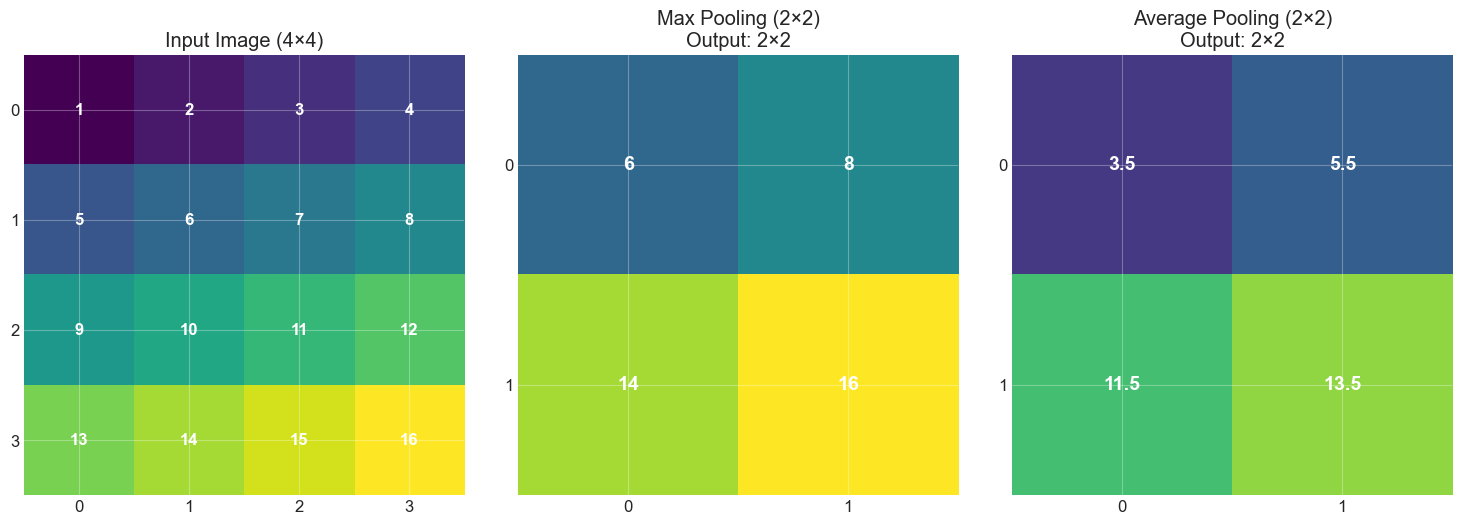

Pooling Example:
Input shape: (4, 4)
Max pooling output: [[ 6.  8.]
 [14. 16.]]
Average pooling output:
[[ 3.5  5.5]
 [11.5 13.5]]


In [8]:
# Pooling Operations
def max_pooling(image, pool_size=2, stride=2):
    """Perform max pooling."""
    H, W = image.shape
    out_h = (H - pool_size) // stride + 1
    out_w = (W - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            h_end = h_start + pool_size
            w_end = w_start + pool_size
            
            region = image[h_start:h_end, w_start:w_end]
            output[i, j] = np.max(region)
    
    return output

def avg_pooling(image, pool_size=2, stride=2):
    """Perform average pooling."""
    H, W = image.shape
    out_h = (H - pool_size) // stride + 1
    out_w = (W - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            h_end = h_start + pool_size
            w_end = w_start + pool_size
            
            region = image[h_start:h_end, w_start:w_end]
            output[i, j] = np.mean(region)
    
    return output

# Create example image
example_img = np.array([[1, 2, 3, 4],
                        [5, 6, 7, 8],
                        [9, 10, 11, 12],
                        [13, 14, 15, 16]])

# Apply pooling
max_pooled = max_pooling(example_img, pool_size=2, stride=2)
avg_pooled = avg_pooling(example_img, pool_size=2, stride=2)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(example_img, cmap='viridis', vmin=1, vmax=16)
axes[0].set_title('Input Image (4×4)')
for i in range(4):
    for j in range(4):
        axes[0].text(j, i, str(example_img[i, j]), ha='center', va='center', 
                    color='white', fontsize=12, weight='bold')
axes[0].set_xticks(range(4))
axes[0].set_yticks(range(4))
axes[0].grid(True, alpha=0.3)

axes[1].imshow(max_pooled, cmap='viridis', vmin=1, vmax=16)
axes[1].set_title('Max Pooling (2×2)\nOutput: 2×2')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(int(max_pooled[i, j])), ha='center', va='center',
                    color='white', fontsize=14, weight='bold')
axes[1].set_xticks(range(2))
axes[1].set_yticks(range(2))
axes[1].grid(True, alpha=0.3)

axes[2].imshow(avg_pooled, cmap='viridis', vmin=1, vmax=16)
axes[2].set_title('Average Pooling (2×2)\nOutput: 2×2')
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, f'{avg_pooled[i, j]:.1f}', ha='center', va='center',
                    color='white', fontsize=14, weight='bold')
axes[2].set_xticks(range(2))
axes[2].set_yticks(range(2))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Pooling Example:")
print(f"Input shape: {example_img.shape}")
print(f"Max pooling output: {max_pooled}")
print(f"Average pooling output:\n{avg_pooled}")

## 5.1.5 Convolutional Neural Networks (LeNet)

By chaining layers and connecting all elements belonging to the convolution, we can build a complete network suitable for various tasks. Usually, at the output of convolutional layers there is one or more FC layers. The purpose of the FC is to allow connection of the information contained in the features collected during the convolutional layers.

We can look at the overall network as two stages:
- **First stage**: Perform feature extraction using convolutional filters, each learning a different feature
- **Second stage**: Connect back all the information collected by connecting all neurons using FC

This architecture was first used in 1998, in a network called **LeNet** (named after Yann LeCun), and is shown in the figure. This network achieved 98.9% accuracy on handwritten digits, where its structure is two convolutional layers and three FC layers, where after each of the convolutional layers pooling is performed.

### LeNet Architecture

1. **Convolutional Layer 1**: 6 filters of size 5×5
2. **Pooling Layer 1**: 2×2 max pooling
3. **Convolutional Layer 2**: 16 filters of size 5×5
4. **Pooling Layer 2**: 2×2 max pooling
5. **Fully Connected Layer 1**: 120 neurons
6. **Fully Connected Layer 2**: 84 neurons
7. **Output Layer**: 10 neurons (for 10 digit classes)

In [9]:
# LeNet Implementation using PyTorch
class LeNet(nn.Module):
    """
    LeNet-5 architecture for digit classification.
    """
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 28×28 → 28×28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)     # 28×28 → 14×14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)          # 14×14 → 10×10
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)     # 10×10 → 5×5
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # Stage 1: Feature extraction
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Stage 2: Classification
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create model
model_lenet = LeNet(num_classes=10)

# Print architecture
print("LeNet Architecture:")
print("=" * 50)
print(model_lenet)
print("\n" + "=" * 50)

# Count parameters
total_params = sum(p.numel() for p in model_lenet.parameters())
trainable_params = sum(p.numel() for p in model_lenet.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
x_test = torch.randn(1, 1, 28, 28)  # Batch of 1, 1 channel, 28×28 image
with torch.no_grad():
    output = model_lenet(x_test)
    print(f"\nInput shape: {x_test.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output (logits): {output[0].numpy()}")

LeNet Architecture:
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Total parameters: 61,706
Trainable parameters: 61,706

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10])
Output (logits): [ 0.13053669 -0.07387703  0.00862582  0.06034984  0.00858065 -0.0713044
 -0.10150157 -0.0376354   0.01746486 -0.04195246]


# 5.2 CNN Architectures

After LeNet, many more efficient and faster networks were developed. In 2012, a network called **AlexNet** based on convolutional layers won the ImageNet competition (an image recognition competition), when it showed a significant improvement over the best result from the previous year.

Along with the improvement in computation, work on deep networks returned to be central and many advanced architectures were developed.

## 5.2.1 AlexNet

AlexNet drew inspiration for its structure from the LeNet architecture, but the more complex structure compared to LeNet comes from the fact that there was more data available, and GPUs already existed that could perform complex calculations.

The architecture contains five convolutional layers and three FC layers, where after the first two convolutional layers pooling and normalization are performed. The input is of dimension 224×224×3, and 96 filters of size 11×11 are applied to it with stride $s=4$ and without zero padding. Therefore, the output of the convolution is of dimension 55×55×96.

After that, max-pooling is performed which reduces the first two dimensions, and a layer of dimension 27×27×96 is obtained. In the second convolutional layer there are 256 filters of size 5×5 with stride size $s=1$ and zero padding $p=2$, so the dimension is 27×27×256, and after max-pooling a layer of dimension 13×13×256 is obtained.

After that there are 2 more convolutional layers with 384 filters of dimension 3×3, stride $s=1$ and padding $p=1$, and then a final convolutional layer with 256 filters of dimension 3×3, with $s=p=1$.

At the output of the convolutions there is another max-pooling, and then three FC layers, where the output of the last layer is a vector of length 1000, representing 1000 different categories in the ImageNet dataset.

The activation function of the network is **ReLU** (unlike LeNet which used tanh), and the hyperparameters are: Dropout=0.5, batch size=128, SGD+momentum=0.9, lr=1e-2. In total, the number of parameters in the network is approximately 60 million.

In [ ]:
# AlexNet Architecture
class AlexNet(nn.Module):
    """
    AlexNet architecture for ImageNet classification.
    """
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        # Feature extraction
        self.features = nn.Sequential(
            # Conv1: 224×224×3 → 55×55×96
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 55×55 → 27×27
            nn.LocalResponseNorm(size=5),  # Normalization
            
            # Conv2: 27×27×96 → 27×27×256
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27×27 → 13×13
            nn.LocalResponseNorm(size=5),
            
            # Conv3: 13×13×256 → 13×13×384
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4: 13×13×384 → 13×13×384
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv5: 13×13×384 → 13×13×256
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13×13 → 5×5 (or 6×6 depending on input)
        )
        
        # Use adaptive pooling to handle different input sizes robustly
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # Ensure consistent size before flattening
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create model
model_alexnet = AlexNet(num_classes=1000)

# Count parameters
total_params = sum(p.numel() for p in model_alexnet.parameters())
print("AlexNet Architecture:")
print("=" * 50)
print(f"Total parameters: {total_params:,} (~60 million)")
print("\nKey Features:")
print("  - ReLU activation (instead of tanh)")
print("  - Local Response Normalization")
print("  - Dropout (0.5)")
print("  - Max pooling after conv1, conv2, conv5")

# Test forward pass
x_test = torch.randn(1, 3, 224, 224)  # ImageNet input size
with torch.no_grad():
    output = model_alexnet(x_test)
    print(f"\nInput shape: {x_test.shape}")
    print(f"Output shape: {output.shape} (1000 classes)")

AlexNet Architecture:
Total parameters: 62,378,344 (~60 million)

Key Features:
  - ReLU activation (instead of tanh)
  - Local Response Normalization
  - Dropout (0.5)
  - Max pooling after conv1, conv2, conv5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6400 and 9216x4096)

## 5.2.2 VGG

A year after ZFNet, a deep network with **19 layers** was presented in the competition, making better use of convolutional layers. The network developers showed that a layer of 7×7 filters can be replaced by three layers of 3×3 filters while maintaining the same receptive field, but with fewer parameters.

For a $d \times d$ filter operating on $c$ input and output channels, there are $d^2 c^2$ learned parameters. Therefore, a 7×7 filter has $49c^2$ parameters, while three layers of 3×3 filters have $3 \cdot 3^2 \cdot c^2 = 27c^2$ learned parameters - a savings of 45%.

The original network is called **VGG16** and contains 138 million parameters, and there is a variation that adds two more convolutional layers called **VGG19**.

### VGG Architecture

- Uses small 3×3 filters throughout
- Deeper than AlexNet (16-19 layers)
- More parameters but better feature extraction
- Standard architecture: conv layers → FC layers

In [ ]:
# VGG16 Architecture (simplified)
def make_vgg_layers(cfg, batch_norm=False):
    """Make VGG layers from configuration."""
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

# VGG16 configuration
cfg_vgg16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
             512, 512, 512, 'M', 512, 512, 512, 'M']

class VGG16(nn.Module):
    """VGG16 architecture."""
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = make_vgg_layers(cfg_vgg16)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create model
model_vgg = VGG16(num_classes=1000)
total_params = sum(p.numel() for p in model_vgg.parameters())

print("VGG16 Architecture:")
print("=" * 50)
print(f"Total parameters: {total_params:,} (~138 million)")
print("\nKey Features:")
print("  - All 3×3 convolutions")
print("  - 16 layers (13 conv + 3 FC)")
print("  - Max pooling after each block")
print("  - Deeper than AlexNet for better feature extraction")

## 5.2.3 GoogleNet

The previous models were computationally expensive due to the large number of parameters. To succeed in achieving the same performance with the same depth but with much fewer parameters, a group of developers from Google presented a concept called **Inception module** - a block that performs many simple operations in parallel, instead of performing one complex operation.

Each block receives an input and performs on it several operations in parallel, and then the outputs of all operations are concatenated. The operations are:
1. 1×1 convolution
2. 1×1 convolution followed by 3×3 convolution with padding of size 1
3. 1×1 convolution followed by 5×5 convolution with padding of size 2
4. 3×3 max pooling with padding 1 followed by 1×1 convolution

Finally, the outputs of the four branches are concatenated together and form the block output.

This structure is equivalent to several networks in parallel, where the advantage of this method is that it has fewer parameters and relatively fast calculations since they are done in parallel. By combining many convolutional layers with this approach, we can find the right ratio between components and the depth of layers that bring optimal performance.

### Inception Module Benefits

- **Reduced parameters**: 1×1 convolutions reduce channels before expensive 3×3 and 5×5
- **Parallel processing**: Multiple paths processed simultaneously
- **Multi-scale features**: Captures features at different scales

In [ ]:
# Inception Module Implementation
class InceptionModule(nn.Module):
    """
    Basic Inception module with 4 parallel branches.
    """
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        
        # Branch 1: 1×1 conv
        self.branch1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        
        # Branch 2: 1×1 → 3×3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=1),
            nn.Conv2d(96, 128, kernel_size=3, padding=1)
        )
        
        # Branch 3: 1×1 → 5×5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2)
        )
        
        # Branch 4: 3×3 max pool → 1×1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 32, kernel_size=1)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # Concatenate along channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return outputs

# Test Inception module
inception = InceptionModule(in_channels=192)
x_test = torch.randn(1, 192, 28, 28)

with torch.no_grad():
    output = inception(x_test)
    
print("Inception Module:")
print("=" * 50)
print(f"Input: {x_test.shape}")
print(f"  Branch 1 (1×1): 64 channels")
print(f"  Branch 2 (1×1→3×3): 128 channels")
print(f"  Branch 3 (1×1→5×5): 32 channels")
print(f"  Branch 4 (pool→1×1): 32 channels")
print(f"Output: {output.shape} (64+128+32+32=256 channels)")

# Count parameters
total_params = sum(p.numel() for p in inception.parameters())
print(f"\nTotal parameters in module: {total_params:,}")
print("\nKey Benefit: Parallel processing of multi-scale features")

## 5.2.4 Residual Networks (ResNet)

After seeing that the deeper the network, the better results it achieves, they tried to build networks with many layers, but they achieved less good results than the previous networks that were on the order of 20 layers.

The problem with deep networks came from the fact that after a certain number of layers, a sufficiently good representation was obtained, and therefore the additional layers should not change the input but pass the representation as is. To do this, the weights in these layers need to be 1.

It turned out that it is difficult for layers to learn the identity function and they actually hurt the result. The challenge came from the difficulty in performing optimization properly for weights in deep layers.

We can formulate the central problem slightly differently - given a network with $N$ layers, it makes sense to add another layer only if it adds information that does not exist until now. To solve this problem, they built a new network using **Residual Blocks** - creating blocks of convolutional layers, where in addition to the information passing through the layers, there is also a connection from the input to the output.

Now if a block performs a certain function $(\mathcal{F}(x))$, then the output is $\mathcal{F}(x) + x$. In this way, if the block learns something different from what was learned so far - the function $\mathcal{F}(x)$ simply remains 0. This structure of the blocks prevents the gradient in deep layers from diverging or vanishing, and training succeeds in converging.

In this way, a network with **152 layers** was developed which achieved better results than all previous networks. The layers were composed of triplets of blocks, where each block has two convolutional layers. Between each triplet there is a doubling of the number of filters and a reduction of the dimension by a factor of two using pooling.

### Residual Block

$$y = \mathcal{F}(x) + x$$

where $\mathcal{F}(x)$ is the learned transformation and $x$ is the identity/skip connection.

In [ ]:
# Residual Block Implementation
class ResidualBlock(nn.Module):
    """
    Basic Residual Block with skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Main path: F(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Skip connection: x
        out += self.shortcut(x)
        
        # Final activation
        out = F.relu(out)
        return out

# Test Residual Block
res_block = ResidualBlock(in_channels=64, out_channels=64, stride=1)
x_test = torch.randn(1, 64, 32, 32)

with torch.no_grad():
    output = res_block(x_test)

print("Residual Block:")
print("=" * 50)
print(f"Input shape: {x_test.shape}")
print(f"Output shape: {output.shape}")
print("\nStructure:")
print("  Main path: Conv → BN → ReLU → Conv → BN")
print("  Skip connection: Identity (or 1×1 conv if dimensions differ)")
print("  Output: F(x) + x")

# Visualize the concept
fig, ax = plt.subplots(figsize=(10, 8))

# Draw residual block diagram
ax.text(1, 3, 'Input $x$', ha='center', fontsize=12, weight='bold')
ax.arrow(1, 2.7, 0, -0.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
ax.text(1, 2, 'Conv + BN', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue'))
ax.arrow(1, 1.7, 0, -0.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
ax.text(1, 1.2, 'ReLU', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen'))
ax.arrow(1, 0.9, 0, -0.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
ax.text(1, 0.4, 'Conv + BN', ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue'))
ax.text(1, 0, '$\\mathcal{F}(x)$', ha='center', fontsize=12, weight='bold')

# Skip connection
ax.plot([1, 3], [3, 0], 'r-', linewidth=3, label='Skip connection $x$')
ax.text(2, 1.5, '+', fontsize=20, ha='center', va='center', color='red')

ax.text(3, 0, 'Output\n$\\mathcal{F}(x) + x$', ha='center', fontsize=12, 
        weight='bold', bbox=dict(boxstyle='round', facecolor='lightyellow'))

ax.set_xlim(-0.5, 4)
ax.set_ylim(-0.5, 3.5)
ax.axis('off')
ax.set_title('Residual Block: $y = \\mathcal{F}(x) + x$', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 5.2.5 Densely Connected Networks (DenseNet)

We can extend the idea of Residual Block so that not only do we connect the input of each block to its output, but we also keep the input itself and check its relationship to deeper layers.

A **Dense Block** is a block built so that the input of each layer is connected to all subsequent layers. We can combine several such blocks together and perform various operations between them like pooling or even an independent convolutional layer.

Since we combine the inputs of several blocks, the number of channels grows, and to prevent the model from becoming too complex, there are **transition layers** at the end of each dense block that perform 1×1 convolution with stride $s=2$, so the number of channels remains reasonable and the model does not become too complex.

### Dense Block

In a dense block, each layer receives feature maps from all preceding layers:

$$x_l = H_l([x_0, x_1, \ldots, x_{l-1}])$$

where $[x_0, x_1, \ldots, x_{l-1}]$ denotes concatenation of feature maps.

In [ ]:
# Dense Block Implementation
class DenseLayer(nn.Module):
    """Single layer in a Dense Block."""
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
    
    def forward(self, x):
        out = F.relu(self.bn(x))
        out = self.conv(out)
        return torch.cat([x, out], dim=1)  # Concatenate along channels

class DenseBlock(nn.Module):
    """Dense Block with multiple dense layers."""
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Test Dense Block
dense_block = DenseBlock(num_layers=4, in_channels=64, growth_rate=32)
x_test = torch.randn(1, 64, 32, 32)

with torch.no_grad():
    output = dense_block(x_test)

print("Dense Block:")
print("=" * 50)
print(f"Input channels: 64")
print(f"Growth rate: 32 (channels added per layer)")
print(f"Number of layers: 4")
print(f"Output channels: {output.shape[1]} (64 + 4×32 = 192)")
print("\nKey Feature: Each layer receives all previous feature maps")

## 5.2.6 U-Net

While CNNs are suitable for classification, at the end of the process a vector of probabilities is obtained for each label. In segmentation tasks this is problematic, because the model cannot map the features in the image back to the pixels of the original image with the appropriate segmentation.

To deal with this problem, they proposed the **U-Net** architecture with three main sections: contraction, bottleneck, and expansion (contraction, bottleneck, and expansion section).

In the contraction section, the image is compressed using convolutional layers with pooling. The difference between this stage and a regular CNN is that there are connections between corresponding layers in the process. After passing through the bottleneck, there is actually reconstruction of the image with segmentation. The reconstruction is done using **up-sampling** on the vector, and the architecture is symmetric to the contraction section.

The loss function used is **pixel-wise cross entropy loss**, which checks each pixel relative to its label.

### U-Net Architecture

- **Encoder (Contraction)**: Downsampling path with conv + pooling
- **Bottleneck**: Lowest resolution features
- **Decoder (Expansion)**: Upsampling path with up-conv + skip connections
- **Skip Connections**: Connect encoder features to decoder at same resolution

In [ ]:
# U-Net Architecture (simplified)
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation.
    """
    def __init__(self, in_channels=1, num_classes=2):
        super(UNet, self).__init__()
        
        # Encoder (contraction)
        self.enc1 = self._conv_block(in_channels, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)
        self.enc4 = self._conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = self._conv_block(512, 1024)
        
        # Decoder (expansion)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self._conv_block(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self._conv_block(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self._conv_block(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self._conv_block(128, 64)
        
        self.final = nn.Conv2d(64, num_classes, 1)
    
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with skip connections
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.final(d1)

# Create model
model_unet = UNet(in_channels=1, num_classes=2)

print("U-Net Architecture:")
print("=" * 50)
print("Encoder (Contraction):")
print("  64 → 128 → 256 → 512 channels")
print("Bottleneck: 1024 channels")
print("Decoder (Expansion):")
print("  512 → 256 → 128 → 64 channels")
print("\nKey Feature: Skip connections preserve spatial information")

# Test
x_test = torch.randn(1, 1, 256, 256)
with torch.no_grad():
    output = model_unet(x_test)
    print(f"\nInput shape: {x_test.shape}")
    print(f"Output shape: {output.shape} (segmentation map)")

In [ ]:
# Transfer Learning Example
# Using a pre-trained ResNet and adapting it for a new task

# Load pre-trained ResNet18
pretrained_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

print("Pre-trained ResNet18:")
print("=" * 50)
print(f"Total parameters: {sum(p.numel() for p in pretrained_resnet.parameters()):,}")

# Freeze all layers
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Replace the final layer for a new task (e.g., 10 classes instead of 1000)
num_new_classes = 10
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, num_new_classes)

# Only the new classifier will be trained
trainable_params = sum(p.numel() for p in pretrained_resnet.parameters() if p.requires_grad)
print(f"\nTrainable parameters (new classifier only): {trainable_params:,}")
print(f"Frozen parameters: {sum(p.numel() for p in pretrained_resnet.parameters()) - trainable_params:,}")

print("\nTransfer Learning Strategy:")
print("  1. Use pre-trained ResNet18 (trained on ImageNet)")
print("  2. Freeze all convolutional layers")
print("  3. Replace final FC layer for new task")
print("  4. Train only the new classifier on new data")

# Example: Fine-tuning (unfreeze last few layers)
print("\n" + "=" * 50)
print("Fine-tuning Strategy:")
# Unfreeze last two blocks
for name, param in pretrained_resnet.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

trainable_finetune = sum(p.numel() for p in pretrained_resnet.parameters() if p.requires_grad)
print(f"Trainable parameters (layer4 + fc): {trainable_finetune:,}")

## Summary

In this chapter, we've covered:

### 5.1 Convolutional Layers
- **5.1.1 From Fully-Connected Layers to Convolutions**: Parameter sharing, feature detection, activation maps
- **5.1.2 Padding, Stride and Dilation**: Hyperparameters controlling convolution behavior
- **5.1.3 Pooling**: Max and average pooling for dimensionality reduction
- **5.1.4 Training**: Shared weights, gradient computation, batch normalization
- **5.1.5 Convolutional Neural Networks (LeNet)**: First successful CNN architecture

### 5.2 CNN Architectures
- **5.2.1 AlexNet**: Deep CNN that won ImageNet 2012, ReLU activation
- **5.2.2 VGG**: Deeper networks with 3×3 filters, 16-19 layers
- **5.2.3 GoogleNet**: Inception modules for efficient parallel processing
- **5.2.4 Residual Networks (ResNet)**: Skip connections solve vanishing gradients
- **5.2.5 Densely Connected Networks (DenseNet)**: Dense blocks with feature reuse
- **5.2.6 U-Net**: Encoder-decoder architecture for segmentation
- **5.2.7 Transfer Learning**: Using pre-trained models for new tasks

### Key Takeaways

- **Convolutional layers** use parameter sharing to dramatically reduce parameters compared to FC layers
- **Padding, stride, and dilation** control the spatial behavior of convolutions
- **Pooling** reduces spatial dimensions while preserving important information
- **CNNs** are highly effective for image data due to spatial structure exploitation
- **Modern architectures** (ResNet, DenseNet) enable training of very deep networks
- **Transfer learning** allows leveraging pre-trained models for new tasks with less data

CNNs form the foundation of modern computer vision and have revolutionized image understanding tasks.